In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report,  roc_curve

In [4]:
def plot_confusion_matrix(y_true, y_pred):

    y_true_normal = y_true.value_counts()[0]
    y_true_fraud = y_true.value_counts()[1]

    cfn_matrix = confusion_matrix(y_true, y_pred)
    cfn_norm_matrix = np.array([[1.0 / y_true_normal, 1.0 / y_true_normal], [1.0 / y_true_fraud, 1.0 / y_true_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('True values')
    plt.xlabel('Predicted values')

    ax = fig.add_subplot(1, 2, 2)
    sns.heatmap(norm_cfn_matrix, cmap='coolwarm_r', linewidths=0.5, annot=True, ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True values')
    plt.xlabel('Predicted values')

    plt.show()

    print('Classification Report')
    print(classification_report(y_true, y_pred))

In [5]:
def plot_roc_curve(fpr, tpr, model):
    plt.figure(figsize=(16, 8))
    plt.title("ROC curve of " + model)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

    plt.show()

Define two functions to plot the confusion matrix and the ROC curve, we use precision/recall and ROC/AUC as the main measurements.

In [6]:
data = pd.read_csv("creditcard.csv")
print(data.head())
print(data.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

Distribution of the Classes in the unsampled dataset
0    284315
1       492
Name: Class, dtype: int64
Normal transactions:  99.83 % of the dataset
Fraudulent transactions:  0.17 % of the dataset


Text(0.5,1,'Normal vs Fraud counts')

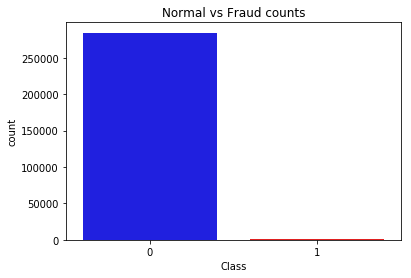

In [7]:
colors = ['b', 'r']

print('Distribution of the Classes in the unsampled dataset')
print(data.Class.value_counts())
print('Normal transactions: ', round(data.Class.value_counts()[0] / len(data) * 100, 2), '% of the dataset')
print('Fraudulent transactions: ', round(data.Class.value_counts()[1] / len(data) * 100, 2), '% of the dataset')


sns.countplot('Class', data=data, palette=colors)
plt.title('Normal vs Fraud counts')

Look at the target variable, this is an imbalanced dataset, in which the ratio between normal and fraudulend transactions is about 1000 : 1. The difficulty is how to resample the imbalanced data. We will use both under-sampling and over-sampling. 

First let us take a look at the features and get a feeling about the data. 

Text(0.5,1,'Normal')

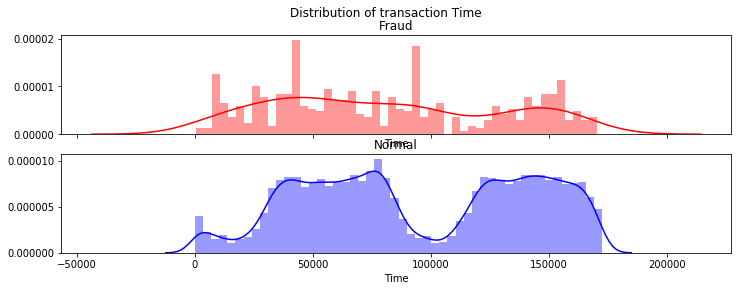

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
plt.suptitle('Distribution of transaction Time')
sns.distplot(data.Time[data.Class == 1], ax=ax1, color='r', bins=50)
ax1.set_title('Fraud')
sns.distplot(data.Time[data.Class == 0], ax=ax2, color='b', bins=50)
ax2.set_title('Normal')

Text(0.5,1,'Normal')

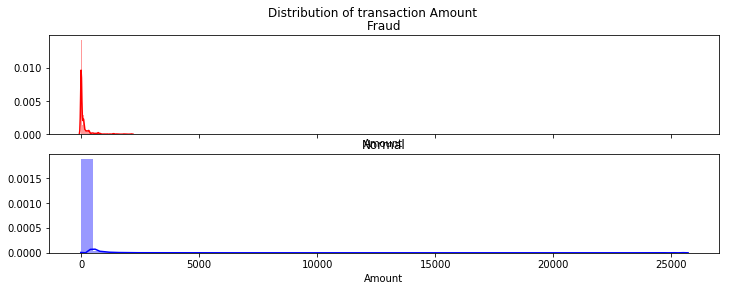

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
plt.suptitle('Distribution of transaction Amount')
sns.distplot(data.Amount[data.Class == 1], ax=ax1, color='r', bins=50)
ax1.set_title('Fraud')
sns.distplot(data.Amount[data.Class == 0], ax=ax2, color='b', bins=50)
ax2.set_title('Normal')

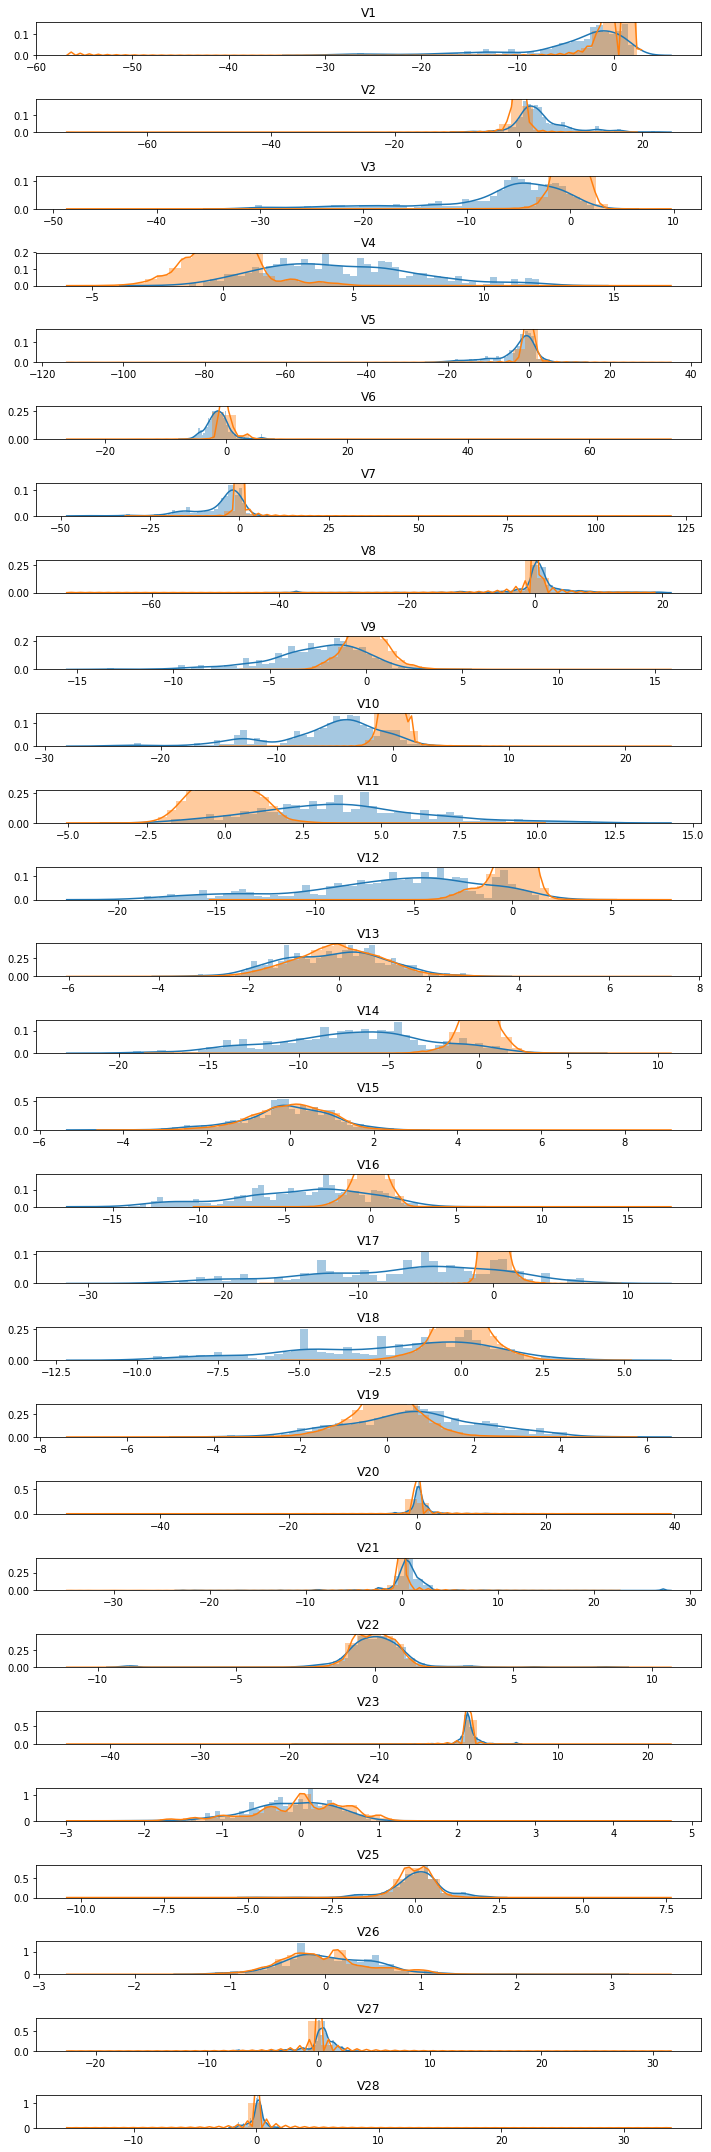

In [10]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(10, 30))
gs = gridspec.GridSpec(28, 1)
for n in range(1, 29):
    ax = plt.subplot(gs[n-1])
    sns.distplot(data['V'+str(n)][data.Class == 1], bins=50)
    sns.distplot(data['V'+str(n)][data.Class == 0], bins=50)
    ax.set_xlabel("")
    ax.set_title('V'+str(n))

plt.tight_layout()

[Text(0,0.5,'Time'),
 Text(0,1.5,'V1'),
 Text(0,2.5,'V2'),
 Text(0,3.5,'V3'),
 Text(0,4.5,'V4'),
 Text(0,5.5,'V5'),
 Text(0,6.5,'V6'),
 Text(0,7.5,'V7'),
 Text(0,8.5,'V8'),
 Text(0,9.5,'V9'),
 Text(0,10.5,'V10'),
 Text(0,11.5,'V11'),
 Text(0,12.5,'V12'),
 Text(0,13.5,'V13'),
 Text(0,14.5,'V14'),
 Text(0,15.5,'V15'),
 Text(0,16.5,'V16'),
 Text(0,17.5,'V17'),
 Text(0,18.5,'V18'),
 Text(0,19.5,'V19'),
 Text(0,20.5,'V20'),
 Text(0,21.5,'V21'),
 Text(0,22.5,'V22'),
 Text(0,23.5,'V23'),
 Text(0,24.5,'V24'),
 Text(0,25.5,'V25'),
 Text(0,26.5,'V26'),
 Text(0,27.5,'V27'),
 Text(0,28.5,'V28'),
 Text(0,29.5,'Amount'),
 Text(0,30.5,'Class')]

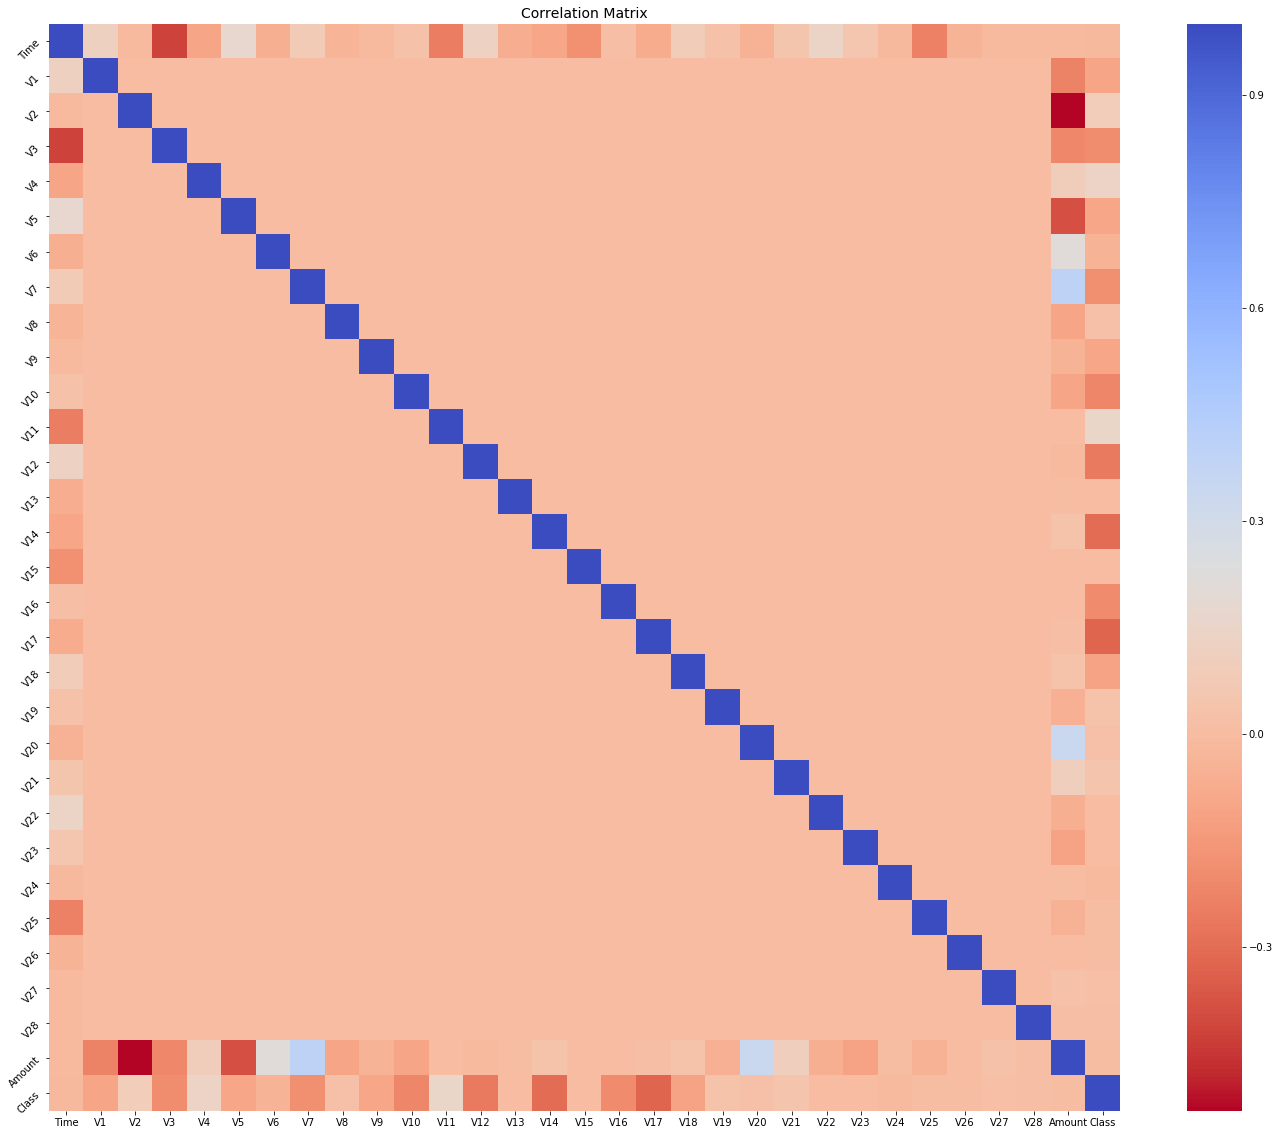

In [11]:
f, ax = plt.subplots(figsize=(24, 20))

corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title("Correlation Matrix", fontsize=14)
ax.set_yticklabels(data.columns, rotation=45)

In order to apply support vector machine, it is better to scale the features. It looks like we only have to standardize 'Time' and 'Amount', other features have been taken care of by PCA. 

In [12]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)

Now let us create a baseline model using linear SVM, where 'class_weight' is set to 1000 : 1.

In [13]:
X = data.drop(['Class'], axis=1)
y = data.Class

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)

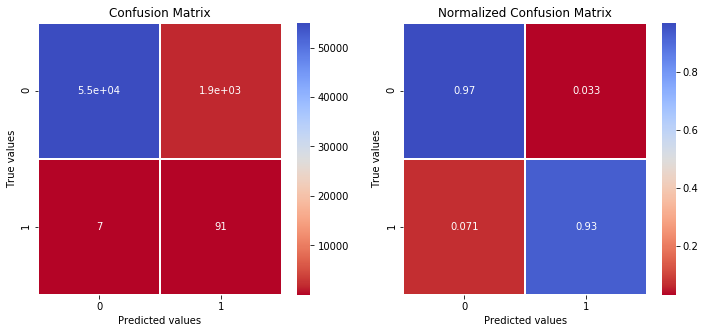

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     56864
          1       0.05      0.93      0.09        98

avg / total       1.00      0.97      0.98     56962



In [14]:
svm = LinearSVC(dual=False, class_weight={1:1000, 0:1})
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

Second, let us under-sample it to create a new dataset with fewer rows, where the ratio between normal and fraudulent transactions is 2 : 1. Of course, you can use 1:1, but it looks like 2:1 improves the performance a little bit. 

In [15]:
df = data.sample(frac=1)

fraud = df.loc[df['Class'] == 1]
normal = df.loc[df['Class'] == 0][:1000]

eq_dist_df = pd.concat([fraud, normal])

df_us = eq_dist_df.sample(frac=1, random_state=42)

Distribution of the Classes after undersampling
0    1000
1     492
Name: Class, dtype: int64
0    0.670241
1    0.329759
Name: Class, dtype: float64


Text(0.5,1,'Equally Distributed Classes')

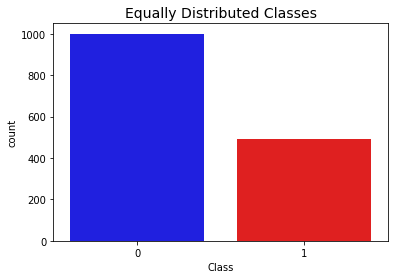

In [16]:
print('Distribution of the Classes after undersampling')
print(df_us.Class.value_counts())
print(df_us['Class'].value_counts()/len(df_us))


fig = plt.figure()
sns.countplot('Class', data=df_us, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)

[Text(0,0.5,'V1'),
 Text(0,1.5,'V2'),
 Text(0,2.5,'V3'),
 Text(0,3.5,'V4'),
 Text(0,4.5,'V5'),
 Text(0,5.5,'V6'),
 Text(0,6.5,'V7'),
 Text(0,7.5,'V8'),
 Text(0,8.5,'V9'),
 Text(0,9.5,'V10'),
 Text(0,10.5,'V11'),
 Text(0,11.5,'V12'),
 Text(0,12.5,'V13'),
 Text(0,13.5,'V14'),
 Text(0,14.5,'V15'),
 Text(0,15.5,'V16'),
 Text(0,16.5,'V17'),
 Text(0,17.5,'V18'),
 Text(0,18.5,'V19'),
 Text(0,19.5,'V20'),
 Text(0,20.5,'V21'),
 Text(0,21.5,'V22'),
 Text(0,22.5,'V23'),
 Text(0,23.5,'V24'),
 Text(0,24.5,'V25'),
 Text(0,25.5,'V26'),
 Text(0,26.5,'V27'),
 Text(0,27.5,'V28'),
 Text(0,28.5,'Class'),
 Text(0,29.5,'scaled_amount'),
 Text(0,30.5,'scaled_time')]

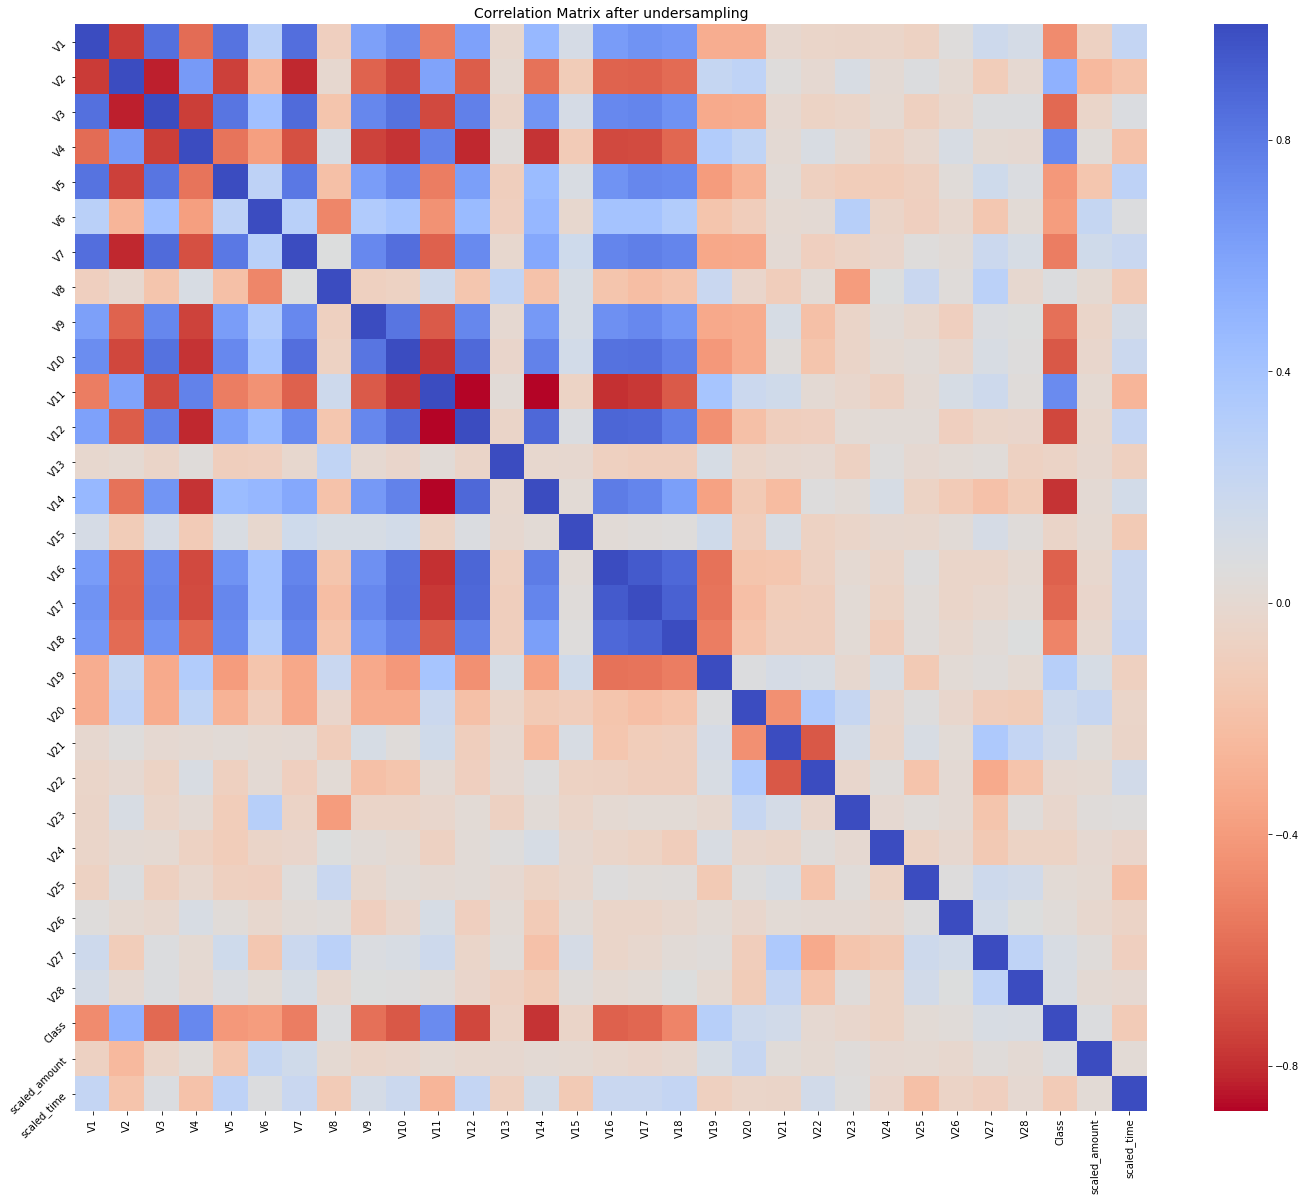

In [17]:
f, ax = plt.subplots(figsize=(24, 20))

sub_sample_corr = df_us.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax)
ax.set_title('Correlation Matrix after undersampling', fontsize=14)
ax.set_yticklabels(df_us.columns, rotation=45)

Now the size of data is really small, we can try expensive methods on it. Let us try cross validation and grid search. 

In [18]:
X = df_us.drop('Class', axis=1)
y = df_us['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearestNeighbors": KNeighborsClassifier(),
    "Support Vector Classifier": SVC()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifier ", classifier.__class__.__name__, "has accuracy score", round(training_score.mean(), 2) * 100, "%")

Classifier  LogisticRegression has accuracy score 95.0 %
Classifier  KNeighborsClassifier has accuracy score 96.0 %
Classifier  SVC has accuracy score 94.0 %


In [20]:
log_reg_params = {"penalty": ['l1', 'l2'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_
print('Best parameters for logit: ', grid_log_reg.best_params_)

Best parameters for logit:  {'C': 1, 'penalty': 'l1'}


In [21]:
knn_params = {"n_neighbors": list(range(2, 5, 1)),
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_train, y_train)
knn = grid_knn.best_estimator_
print('Best parameters for kNN: ', grid_knn.best_params_)

Best parameters for kNN:  {'algorithm': 'auto', 'n_neighbors': 3}


In [22]:
svc_params = {'C': np.logspace(-3, 2, 6),
              'kernel': ['linear'],
              'gamma': np.logspace(-3, 2, 6)}

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_
print("Best parameters for SVC: ", grid_svc.best_params_)

Best parameters for SVC:  {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}


In [23]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.56%


In [24]:
knears_score = cross_val_score(knn, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

Knears Neighbors Cross Validation Score 95.89%


In [25]:
svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

Support Vector Classifier Cross Validation Score 94.89%


ROC_AUC score of logit:  0.9814613604217565


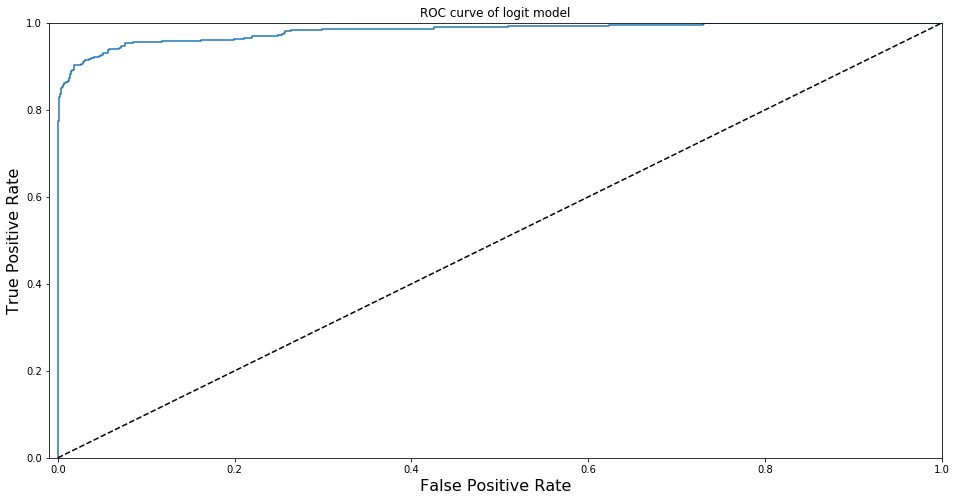

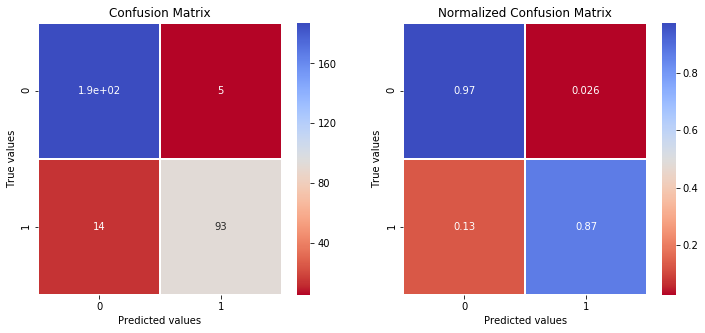

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       192
          1       0.95      0.87      0.91       107

avg / total       0.94      0.94      0.94       299



In [26]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
print("ROC_AUC score of logit: ", roc_auc_score(y_train, log_reg_pred))
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
plot_roc_curve(log_fpr, log_tpr, "logit model")
y_pred = log_reg.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

ROC_AUC score of kNN:  0.9431625305387682


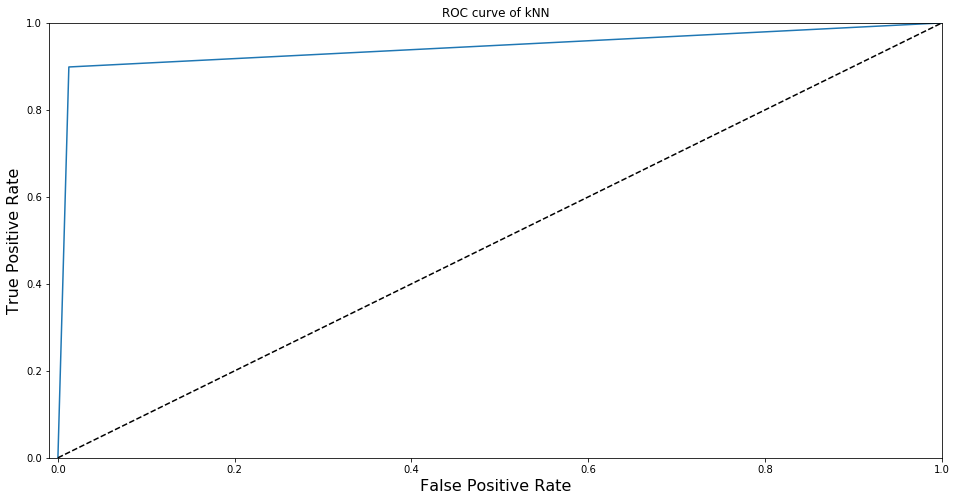

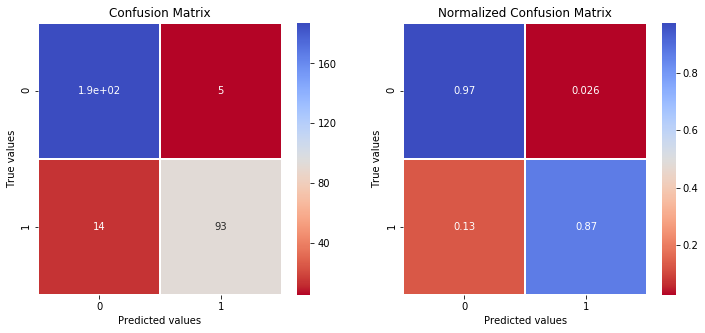

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.97      0.95       192
          1       0.95      0.87      0.91       107

avg / total       0.94      0.94      0.94       299



In [27]:
knn_pred = cross_val_predict(knn, X_train, y_train, cv=5)
print("ROC_AUC score of kNN: ", roc_auc_score(y_train, knn_pred))
knn_fpr, knn_tpr, knn_thresold = roc_curve(y_train, knn_pred)
plot_roc_curve(knn_fpr, knn_tpr, "kNN")
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

ROC_AUC score of svc:  0.9833804809052333


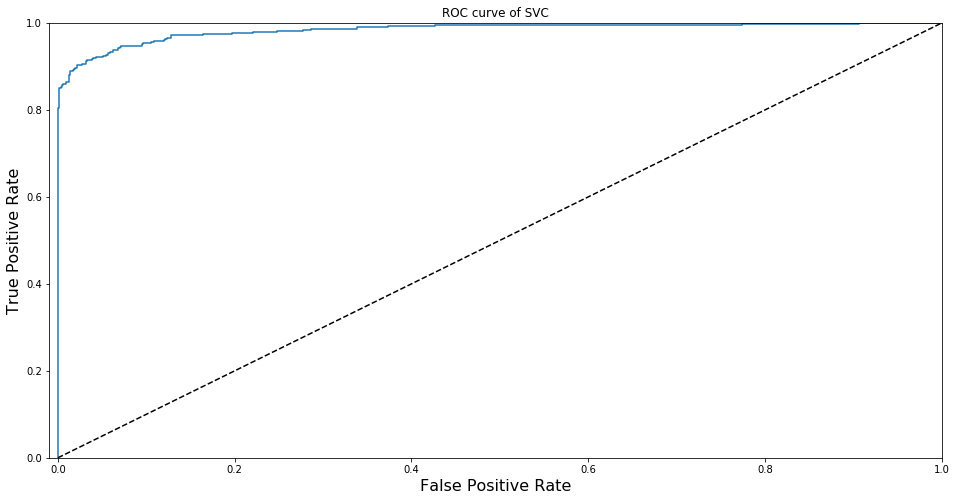

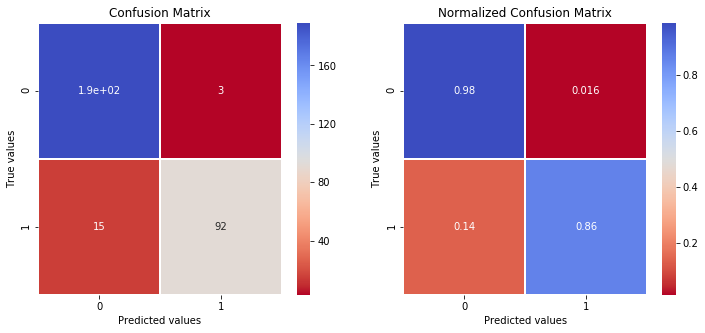

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.98      0.95       192
          1       0.97      0.86      0.91       107

avg / total       0.94      0.94      0.94       299



In [28]:
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
print("ROC_AUC score of svc: ", roc_auc_score(y_train, svc_pred))
svc_fpr, svc_tpr, svc_thresold = roc_curve(y_train, svc_pred)
plot_roc_curve(svc_fpr, svc_tpr, "SVC")
y_pred = svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

Third, let us try over-sampling, here we use ADASYN from imblearn.over_sampling.

In [29]:
data = pd.read_csv("creditcard.csv")

from sklearn.utils import shuffle

fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])

X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac=0.8)], axis=0)

remainder = data.loc[~data.index.isin(X_train.index)]
X_test = remainder.sample(frac=1)

In [30]:
from imblearn.over_sampling import ADASYN

ada = ADASYN()
X_train_resampled, X_train_labels_resampled = ada.fit_sample(np.array(X_train.ix[:, X_train.columns != 'Class']),
                                                       np.array(X_train.Class))

/home/danli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [31]:
from collections import Counter
print(Counter(X_train_labels_resampled))

Counter({0: 227452, 1: 227377})


In [32]:
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_labels_resampled = pd.DataFrame(X_train_labels_resampled)
X_train_resampled = pd.concat([X_train_resampled, X_train_labels_resampled], axis=1)
X_train_resampled.columns = X_train.columns

In [33]:
X_train = shuffle(X_train_resampled)
X_test = shuffle(X_test)

df_os = pd.concat([X_train, X_test])
print(df_os.head())
print(df_os.info())

                 Time        V1        V2         V3        V4        V5  \
224563  153117.000000  1.972455 -0.269062  -0.760432  0.298935 -0.259169   
284714  151779.803414 -3.653313  3.169943  -6.581971  6.330053 -0.241770   
423478  102655.174474 -8.896950  7.621782 -10.415769  8.648979 -5.069705   
421690   61651.086422 -1.523209  1.518074   0.332991  2.295978 -0.549623   
380029   34664.047782 -0.343611  2.511683  -3.989195  4.651394 -1.667397   

              V6         V7        V8        V9  ...         V21       V22  \
224563 -0.469318  -0.218894  0.006008  0.900920  ...   -0.441499 -1.211267   
284714 -1.992737  -3.229150 -0.539162 -1.584257  ...    0.136896  0.752707   
423478 -0.427377 -11.636337 -3.279037 -5.764150  ...   -2.183625  1.552675   
421690  0.980548  -1.101505 -0.012066 -0.550163  ...    0.336092  0.490349   
380029 -1.310396  -4.091882  0.966774 -3.100205  ...    0.879382 -0.011292   

             V23       V24       V25       V26       V27       V28     Amo

In [35]:
for feature in X_train.columns.values[:-1]:
    mean, std = df_os[feature].mean(), df_os[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [36]:
y_train = X_train.Class
y_test = X_test.Class
X_train = X_train.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)

In [37]:
datadict = {
    'X_train' : X_train,
    "X_test" : X_test,
    'y_train' : y_train,
    'y_test' : y_test
}


for k, v in datadict.items():
    if 'y' in k:
        print(k, Counter(v))

y_train Counter({0: 227452, 1: 227377})
y_test Counter({0: 56863, 1: 98})


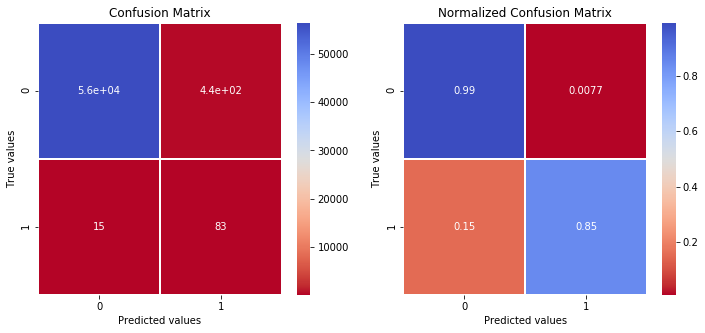

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     56863
          1       0.16      0.85      0.27        98

avg / total       1.00      0.99      0.99     56961



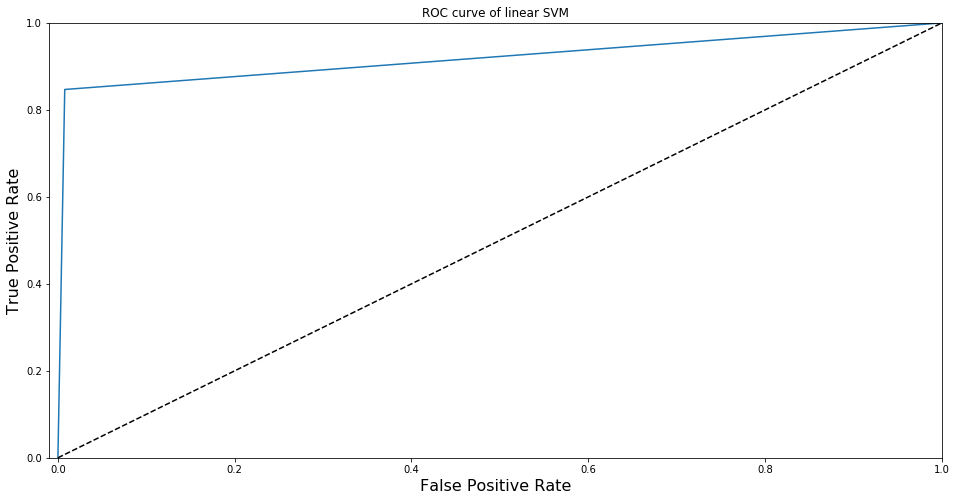

In [38]:
lsvm = LinearSVC(C=1.0, dual=False)
lsvm.fit(X_train, y_train)
y_pred = lsvm.predict(X_test)
plot_confusion_matrix(y_test, y_pred)


fpr, tpr, _ = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr, "linear SVM") 